# Comparison

We’re looking at the state-value function estimation error using the mean absolute error across all estimates from their respective optimal.

In [1]:
import random
import numpy as np
        
class Space:
    def __init__(self, value):
        self.n = value
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(9)
        self.action_space = Space(2)
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
env = SlipperyWalk()

In [3]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]

In [12]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [13]:
from itertools import count

def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon) 
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

In [14]:
def mc_control(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) 
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    for e in range(n_episodes):
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        visited = np.zeros((nS, nA), dtype=bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action]: continue
            visited[state][action] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [15]:
def sarsa(env, gamma=1.0,
          init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, 
          n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    for e in range(n_episodes):
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)
            state, action = next_state, next_action
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [16]:
def q_learning(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)
            state = next_state
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [17]:
def double_q_learning(env,gamma=1.0,
                      init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                      init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                      n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            state = next_state    
        Q = (Q1 + Q2)/2.
        V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))
    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [18]:
def sarsa_lambda(env, gamma=1.0,
                 init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                 init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                 lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    E = np.zeros((nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon,  epsilon_decay_ratio, n_episodes)
    for e in range(n_episodes):
        E.fill(0)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            V = np.max(Q, axis=1)
            state, action = next_state, next_action
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [19]:
def q_lambda(env, gamma=1.0,
             init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
             init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    E = np.zeros((nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    for e in range(n_episodes):
        E.fill(0)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            if next_action_is_greedy: E = gamma * lambda_ * E
            else: E.fill(0)
            state, action = next_state, next_action
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [20]:
_, _, _, _, V_track_mc, _ = mc_control(env)
_, _, _, _, V_track_sarsa, _ = sarsa(env)
_, _, _, _, V_track_q, _ = q_learning(env)
_, _, _, _, V_track_dq, _ = double_q_learning(env)
_, _, _, _, V_track_sarsa_lambda, _ = sarsa_lambda(env)
_, _, _, _, V_track_q_lambda, _ = q_lambda(env)

In [21]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

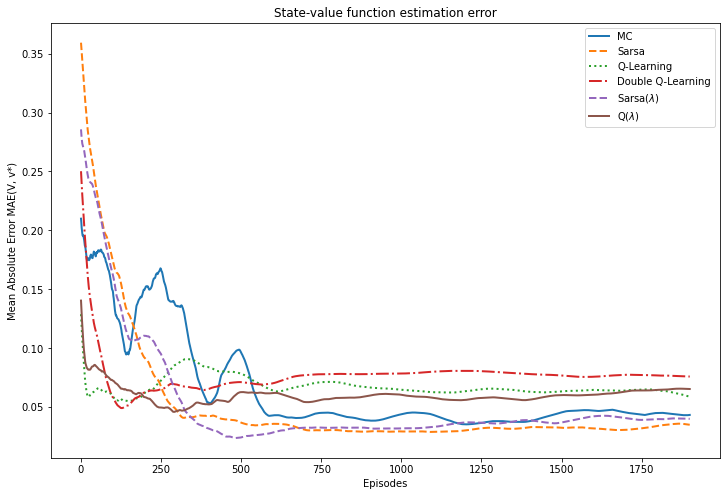

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_mc - optimal_V), axis=1)), '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(V_track_q - optimal_V), axis=1)), ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), '-.', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Q($\lambda$)')
plt.legend(loc=1, ncol=1)
plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()